In [9]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [10]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = int(W * cut_rat)
    cut_h = int(H * cut_rat)
    cx = np.random.randint(W)
    cy = np.random.randint(H)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

def cutmix_batch(images, labels, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size = images.size(0)
    indices = torch.randperm(batch_size)
    shuffled_images = images[indices]
    shuffled_labels = labels[indices]
    bbx1, bby1, bbx2, bby2 = rand_bbox(images.size(), lam)
    images[:, :, bby1:bby2, bbx1:bbx2] = shuffled_images[:, :, bby1:bby2, bbx1:bbx2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (images.size(-1) * images.size(-2)))
    labels_onehot = torch.nn.functional.one_hot(labels, num_classes=10).float()
    shuffled_onehot = torch.nn.functional.one_hot(shuffled_labels, num_classes=10).float()
    mixed_labels = lam * labels_onehot + (1 - lam) * shuffled_onehot
    return images, mixed_labels

In [11]:
transform = transforms.ToTensor()
dataset = torchvision.datasets.CIFAR10(root='../data', train=True, download=True, transform=transform)
loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)

In [12]:
aug_images = []
aug_labels = []

for images, labels in loader:
    cut_images, cut_labels = cutmix_batch(images, labels, alpha=1.0)
    aug_images.append(cut_images)
    aug_labels.append(cut_labels)

In [13]:
aug_images = torch.cat(aug_images)
aug_labels = torch.cat(aug_labels)

torch.save((aug_images, aug_labels), 'data/cutmix_cifar10_train.pt')

## Saving for FFCV

In [57]:
import torch
from ffcv.writer import DatasetWriter
from ffcv.fields import RGBImageField, NDArrayField
from torch.utils.data import TensorDataset

In [58]:
images, labels = torch.load('data/cutmix_cifar10_train.pt')
images_np = (images.permute(0, 2, 3, 1).numpy() * 255).astype(np.uint8)
labels_np = labels.numpy().astype(np.float32)

In [59]:
class NumpyDataset:
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img   = self.images[idx]
        label = self.labels[idx]
        assert isinstance(img,   np.ndarray), f"Image at idx {idx} is not ndarray but {type(img)}"
        assert isinstance(label, np.ndarray), f"Label at idx {idx} is not ndarray but {type(label)}"

        return img, label


dataset = NumpyDataset(images_np, labels_np)

In [60]:
fields = {
    'image': RGBImageField(write_mode='smart', max_resolution=32),
    'label': NDArrayField(dtype=np.dtype('float32'), shape=(10,))
}

In [61]:
writer = DatasetWriter('data/cutmix_cifar10_train.beton', fields)
writer.from_indexed_dataset(dataset)







  0%|          | 0/50000 [00:00<?, ?it/s]





100%|██████████| 50000/50000 [00:00<00:00, 70762.28it/s] 


## Check

In [65]:
from ffcv.loader import Loader, OrderOption
from ffcv.transforms import ToTensor, ToDevice, ToTorchImage
from ffcv.fields.decoders import NDArrayDecoder, SimpleRGBImageDecoder

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_pipeline = [
    SimpleRGBImageDecoder(),
    ToTensor(),
    ToTorchImage(),
    ToDevice(device, non_blocking=True)
]

label_pipeline = [
    NDArrayDecoder(),
    ToTensor(),
    ToDevice(device, non_blocking=True)
]

pipelines = {
    'image': image_pipeline,
    'label': label_pipeline
}

loader = Loader(
    'data/cutmix_cifar10_train.beton',
    batch_size=128,
    num_workers=4,
    order=OrderOption.RANDOM,
    pipelines=pipelines
)

for images, labels in loader:
    print(images.shape)
    print(labels.shape)
    break


torch.Size([128, 3, 32, 32])
torch.Size([128, 10])


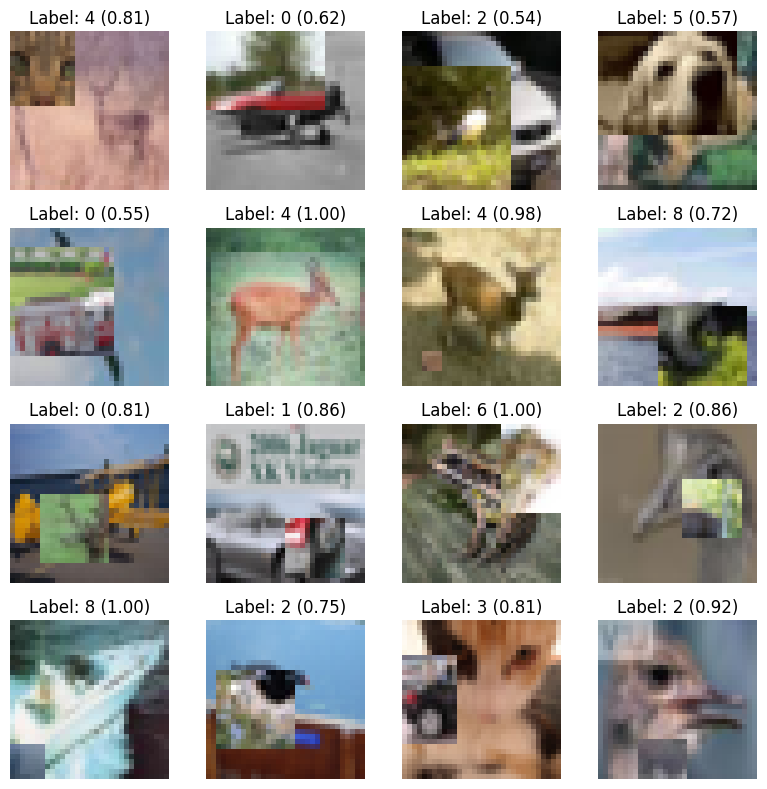

In [66]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

images, labels = next(iter(loader))


images = images[:16].cpu()
labels = labels[:16].cpu()


fig, axs = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axs.flatten()):
    img = TF.to_pil_image(images[i])
    ax.imshow(img)


    label_idx = torch.argmax(labels[i]).item()
    label_val = labels[i][label_idx].item()
    ax.set_title(f"Label: {label_idx} ({label_val:.2f})")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Imported CutMix

In [2]:
import torch
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.transforms.v2 import CutMix
from torch.utils.data import DataLoader
from tqdm import tqdm

In [3]:
dataset = CIFAR10(root='../data', train=True, download=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=128, shuffle=True, num_workers=4)

cutmix = CutMix(num_classes=10, alpha=1.0)

aug_images = []
aug_labels = []

for images, labels in tqdm(loader, desc='Applying CutMix'):
    mixed = cutmix((images, labels))
    imgs, lbls = mixed
    aug_images.append(imgs)
    aug_labels.append(lbls)

aug_images = torch.cat(aug_images)
aug_labels = torch.cat(aug_labels)

torch.save((aug_images, aug_labels), '../data/cifar10_cutmix.pt')

Applying CutMix: 100%|██████████| 391/391 [00:01<00:00, 382.37it/s]


## Save for FFCV

In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset
import os

torch.set_num_threads(1)

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"

In [12]:
from ffcv.writer import DatasetWriter
from ffcv.fields import RGBImageField, NDArrayField

aug_images_np = (aug_images.permute(0, 2, 3, 1).numpy() * 255).astype(np.uint8)
aug_labels_np = aug_labels.numpy().astype(np.float32)

class CutMixCIFAR10Dataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

cutmix_dataset = CutMixCIFAR10Dataset(aug_images_np, aug_labels_np)
write_path = 'data/cifar10_cutmix.beton'

writer = DatasetWriter(write_path, {
    'image': RGBImageField(),
    'label': NDArrayField(dtype=np.dtype('float32'), shape=(10,))
})
writer.from_indexed_dataset(cutmix_dataset)

/home/amir_ubuntu/.virtualenvs/transformer-model-optimization/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 50000/50000 [00:00<00:00, 62354.24it/s] 


### Check

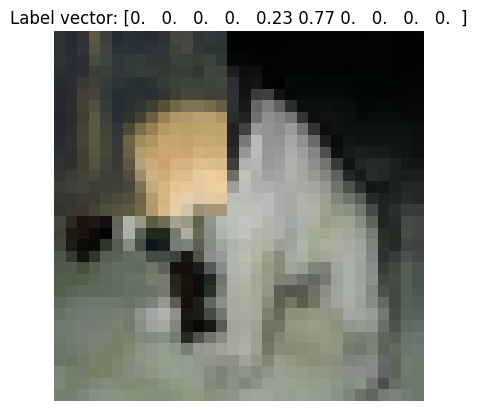

In [9]:
from ffcv.loader import Loader, OrderOption
from ffcv.fields.decoders import SimpleRGBImageDecoder, NDArrayDecoder
from ffcv.transforms import ToTensor
import matplotlib.pyplot as plt
import numpy as np
import torch

beton_path = './data/cifar10_cutmix.beton'

loader = Loader(
    beton_path,
    batch_size=1,
    num_workers=0,
    order=OrderOption.SEQUENTIAL,
    pipelines={
        'image': [SimpleRGBImageDecoder(), ToTensor()],
        'label': [NDArrayDecoder(), ToTensor()]
    }
)

# Получаем один пример
for images, labels in loader:
    image = images[0].numpy() / 255.0  # [H, W, C], уже готово к imshow
    label = labels[0].numpy()
    break

# Визуализация
plt.imshow(image)
plt.title(f"Label vector: {np.round(label, 2)}")
plt.axis('off')
plt.show()
